In [2]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 8.0 MB/s eta 0:00:00a 0:00:01


In [3]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
from IPython.display import Audio
import numpy as np
import pandas as pd
import pickle
import yaml

from lib import utils
from lib.notebooks import plot_groups_metrics
from communicative_agent import CommunicativeAgent

/tmp/ipykernel_2888/4271051895.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
NB_TRAINING = 5
JERK_LOSS_WEIGHTS = [0.1, 0.15]

In [5]:
metrics_name = ["inverse_model_jerk", "inverse_model_repetition_error"]
groups_metrics = { metric_name: {} for metric_name in metrics_name }

final_configs = utils.read_yaml_file("communicative_final_configs.yaml")
final_quantizer_configs = utils.read_yaml_file("../quantizer/quantizer_final_configs.yaml")

for config_name, config in final_configs.items():
    quantizer_name = config_name.split("-")[0]
    quantizer_config = final_quantizer_configs["%s-cepstrum" % quantizer_name]

    for i_training in range(NB_TRAINING):
        quantizer_config["dataset"]["datasplit_seed"] = i_training
        quantizer_signature = utils.get_variable_signature(quantizer_config)

        for jerk_loss_weight in JERK_LOSS_WEIGHTS:
            config["sound_quantizer"]["name"] = "%s-%s" % (quantizer_signature, i_training)
            config["training"]["jerk_loss_weight"] = jerk_loss_weight

            agent_group = "%s jerk=%s" % (config_name, jerk_loss_weight)
            
            agent_signature = utils.get_variable_signature(config)
            agent_name = "%s-%s" % (agent_signature, i_training)
            print(jerk_loss_weight)
            print(agent_name)
            agent_path = "../out/communicative_agent/%s" % agent_name
            with open("%s/metrics.pickle" % agent_path, "rb") as f:
                metrics = pickle.load(f)
            
            final_loss_index = np.argmin(metrics["validation"]["inverse_model_repetition_error"])
            
            for metric_name in metrics_name:
                if agent_group not in groups_metrics[metric_name]:
                    groups_metrics[metric_name][agent_group] = []
                agent_metric = metrics["test"][metric_name][final_loss_index]
                groups_metrics[metric_name][agent_group].append(agent_metric)

0.1
29ad219b4b0a7b1f1a04feaea94149ed-0
0.15
5e5dce5ba23ccc653b8cb0cbd29c7cc9-0
0.1
0829fe5eb136a69bf08f1f7969363bc8-1
0.15
ab6a5478e5bc27aca498e1b80439f22b-1
0.1
a0211aef905f79c8db4e624ba5d84026-2
0.15
255f581101c5169ce56d919198f62c33-2
0.1
d9c1824418a0f15340b3a5f5a39f8118-3
0.15
aabf90478c0629fd266913e4b0ea1b72-3
0.1
0458b50b843eb9a9cdd308c21f0c023f-4
0.15
8b2ea1d806d35213698be3161ab02bbb-4
0.1
b2d298b15deafecafba924000330a834-0
0.15
f103235e599e91d1d8f16726de633c41-0
0.1
ff12acf842bc5d99bd2480b0a879414f-1
0.15
4ea8e7d887c3aa4692d5c1a162087f11-1
0.1
f7cd32e29de7f6a778dac9697491d7ad-2
0.15
4936c9a76095bd94ddd8ce4f066b8bde-2
0.1
b43eb90124f06a973b74e342c96a908f-3
0.15
8969824d55dc82ed4a29661da4ffdb1d-3
0.1
2ab5a89f4f49a9598d6b004ef67ff3e1-4
0.15
5b6a02d2fc806a8d8f6c93b3d0fb6202-4
0.1
77cf3c62cfdac0a138ecf5b39268460e-0
0.15
f9267acf418cdd4e7bf5809cc9402b3b-0
0.1
756a9967e1e76dbaa911ef49498898fd-1
0.15
2dc4661008775a91132083da4874e49e-1
0.1
9d95d0abedf714185ce9cdcf639b45ea-2
0.15
739688f2

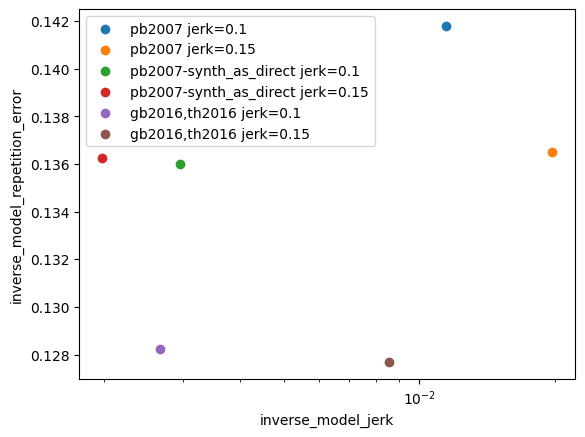

In [6]:
plot_metrics = ["inverse_model_jerk", "inverse_model_repetition_error"]
plot_scales = ["log", "linear"]

plt.figure()
ax = plt.subplot()
ax.set_xlabel(plot_metrics[0])
ax.set_ylabel(plot_metrics[1])
ax.set_xscale(plot_scales[0])
ax.set_yscale(plot_scales[1])

groups_name = groups_metrics[plot_metrics[0]].keys()
for group_name in groups_name:
    x = np.mean(groups_metrics[plot_metrics[0]][group_name])
    y = np.mean(groups_metrics[plot_metrics[1]][group_name])
    ax.scatter(x, y, label=group_name)
ax.legend()
plt.show()